In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(8,6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.patches as patches

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import scipy.io as sio

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(1)

import seaborn as sns
import pandas as pd
from astropy.io import fits

sns.set(font_scale=2)
sns.set_style("white", {"axes.grid": "False"})
sns.set_style("ticks")

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [2]:
warnings.filterwarnings('ignore')

candels_cat_z1 = np.loadtxt('../catalogs/CANDELS_GDSS_workshop_z1.dat')

# subtracting 1 from the ID for python indexing
cat_z1_ids = candels_cat_z1[0:,0] - 1
cat_z1_z = candels_cat_z1[0:,1]

print(str(cat_z1_z.shape[0])+' galaxies in the z~1 catalog.')

ircat = np.genfromtxt('../catalogs/CANDELS_GDSS_workshop_z1_fluxes_Jy_UVtoIR.dat')
print(ircat.shape)

# ID      zz                   1
# CTIO_U             eCTIO_U    3        
# VIMOS_U            eVIMOS_U    5       
# ACS_F435W          eACS_F435W   7      
# ACS_F606W          eACS_F606W    9     
# ACS_F775W          eACS_F775W     11    
# ACS_F814W          eACS_F814W      13   
# ACS_F850LP         eACS_F850LP       15 
# WFC3_F098M   eWFC3_F098M   17
# WFC3_F105W         eWFC3_F105W 19       
# WFC3_F125W         eWFC3_F125W   21     
# WFC3_F160W         eWFC3_F160W     23   
# ISAAC_KS           eISAAC_KS         25 
# HAWKI_KS           eHAWKI_KS          27
# IRAC_CH1           eIRAC_CH1          29
# IRAC_CH2           eIRAC_CH2          31
# IRAC_CH3           eIRAC_CH3          33
# IRAC_CH4           eIRAC_CH4          35
# f24            ef24           37
# f70            ef70           39
# f100           ef100          41
# f160           ef160          43
# f250           ef250          45
# flg1   flg2  47


371 galaxies in the z~1 catalog.
(371, 48)


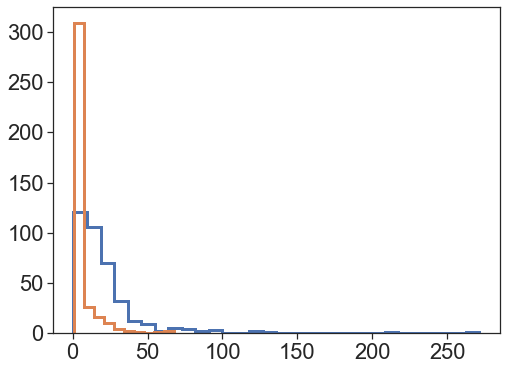

In [3]:
zz = ircat[0:,1]
f160 = -2.5*np.log10(ircat[0:,22])+8.9
f435_snr = ircat[0:,6]/ircat[0:,7]
f24_snr = ircat[0:,36]/ircat[0:,37]
f100_snr = ircat[0:,40]/ircat[0:,41]
plt.hist(f435_snr,30,histtype='step',lw=3)
plt.hist(f24_snr,10,histtype='step',lw=3)
# plt.hist(f100_snr,50,histtype='step',lw=3)
plt.show()

In [4]:
thrs = 5
print(np.sum((f24_snr>thrs) & (f100_snr>thrs)))
print(np.sum((f24_snr>thrs)))
print(np.sum(f24_snr>0))

40
85
371


# Prospector

371


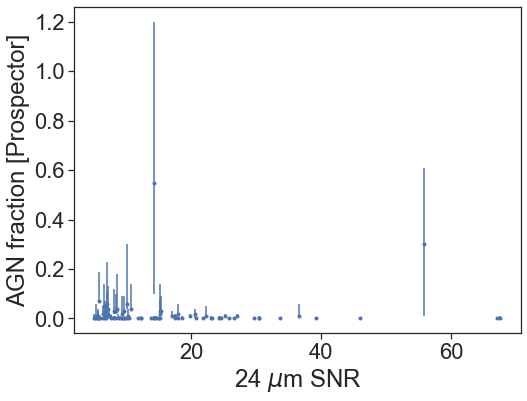

In [5]:
prospector_full = pd.read_table("../code_outputs_IR/prospector_output_z1_ir_agn_f.dat",sep='\s+')
prospector_full.head()
print(len(prospector_full))

prospector_id = prospector_full['objname']
prospector_agnf = prospector_full['fagn']
prospector_agnfeup = prospector_full['fagn_errup']
prospector_agnfedo = prospector_full['fagn_errdown']

plt.plot(f24_snr[(f24_snr>thrs)], prospector_agnf[(f24_snr>thrs)],'.')
plt.errorbar(f24_snr[(f24_snr>thrs)], prospector_agnf[(f24_snr>thrs)], yerr=[prospector_agnfedo[(f24_snr>thrs)],prospector_agnfeup[(f24_snr>thrs)]], fmt='none')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [Prospector]')
plt.show()


# AGNFitter

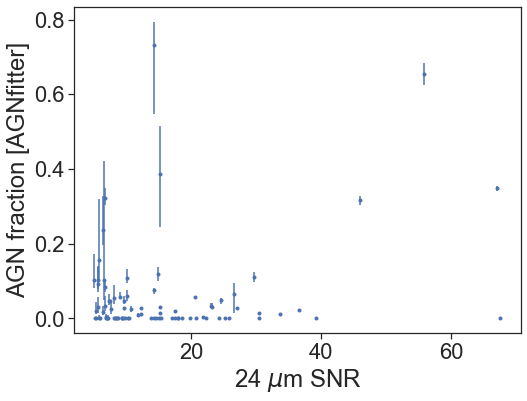

In [6]:
#This is the file with the AGN fraction
agnfitter_full = fits.open('../code_outputs_IR/AGNfitter_CANDELSoutput_24umdet_EB1prior.fits')

agnfitter_full[1].header

# internal IDs, aren't ordered by CANDELS ID

agnfitter_id = agnfitter_full[1].data['ID']
agnfitter_af = agnfitter_full[1].data['AGNfrac']
agnfitter_afeup = agnfitter_full[1].data['AGNfrac+e']
agnfitter_afedo = agnfitter_full[1].data['AGNfrac-e']

# matched to CANDELS ID array

agnfitter_ids = np.zeros((len(cat_z1_ids),))
agnfitter_agnfracs = np.zeros((len(cat_z1_ids),))
agnfitter_agnfracs_eup = np.zeros((len(cat_z1_ids),))
agnfitter_agnfracs_edo = np.zeros((len(cat_z1_ids),))

for i in range(len(agnfitter_id)):

    temp = agnfitter_id[i]
    id_index = np.argmin(np.abs(temp - cat_z1_ids+1))
    agnfitter_ids[id_index] = temp
    agnfitter_agnfracs[id_index] = agnfitter_af[i]
    agnfitter_agnfracs_eup[id_index] = agnfitter_afeup[i]
    agnfitter_agnfracs_edo[id_index] = agnfitter_afedo[i]

plt.plot(f24_snr[(f24_snr>thrs)], agnfitter_agnfracs[(f24_snr>thrs)],'.')
plt.errorbar(f24_snr[(f24_snr>thrs)], agnfitter_agnfracs[(f24_snr>thrs)],yerr=[agnfitter_agnfracs_edo[(f24_snr>thrs)],agnfitter_agnfracs_eup[(f24_snr>thrs)]],fmt='none')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [AGNfitter]')
plt.show()

agnfitter_full.close()

# MAGPHYS

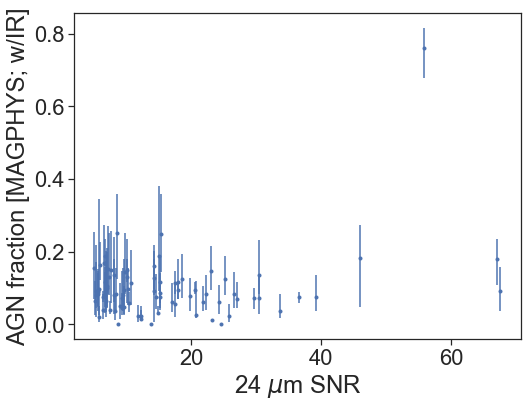

In [7]:
# with IR

magphys_IR_full = fits.open('../code_outputs_IR/magphys_output_z1_ir.fits')
# magphys_IR_full.info()
# magphys_IR_full[1].header

# internal IDs, aren't ordered by CANDELS ID
magphys_IR_af = magphys_IR_full[1].data['agnf50_agn']
magphys_IR_afedo = magphys_IR_full[1].data['agnf50_agn']-magphys_IR_full[1].data['agnf16_agn']
magphys_IR_afeup = magphys_IR_full[1].data['agnf84_agn']-magphys_IR_full[1].data['agnf50_agn']

# matched to CANDELS ID array
magphys_ir_ids = np.zeros((len(cat_z1_ids),))
magphys_agnfracs_z1_IR = np.zeros((len(cat_z1_ids),))
magphys_agnfracs_eup_z1_IR = np.zeros((len(cat_z1_ids),))
magphys_agnfracs_edo_z1_IR = np.zeros((len(cat_z1_ids),))

for i in range(len(magphys_IR_full[1].data)):

    temp = magphys_IR_full[1].data[i][0]
    id_index = np.argmin(np.abs(cat_z1_ids - float(temp[0:-4])))

    magphys_ir_ids[id_index] = float(temp[0:-4])
    magphys_agnfracs_z1_IR[id_index] = magphys_IR_af[i]
    magphys_agnfracs_eup_z1_IR[id_index] = magphys_IR_afeup[i]
    magphys_agnfracs_edo_z1_IR[id_index] = magphys_IR_afedo[i]

magphys_IR_full.close()

      
plt.plot(f24_snr[(f24_snr>thrs)], magphys_agnfracs_z1_IR[(f24_snr>thrs)],'.')
plt.errorbar(f24_snr[(f24_snr>thrs)], magphys_agnfracs_z1_IR[(f24_snr>thrs)],yerr=[magphys_agnfracs_edo_z1_IR[(f24_snr>thrs)],magphys_agnfracs_eup_z1_IR[(f24_snr>thrs)]],fmt='none')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [MAGPHYS; w/IR]')
plt.show()


# SED3FIT

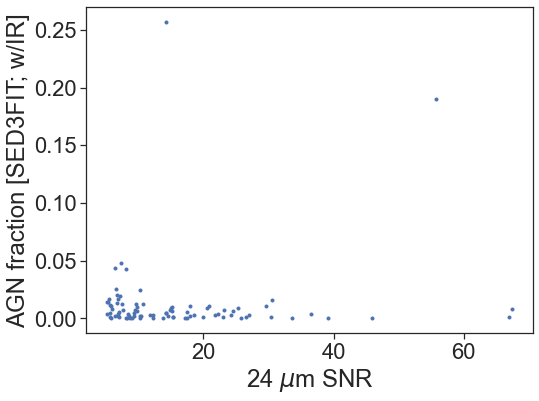

In [8]:

#sed3fit_ir_cat = np.genfromtxt('code_outputs_IR/RIVERSIDE_z1_IR_SED3FIT_RESULTS_8_2.dat')
sed3fit_cat = np.genfromtxt('../code_outputs_IR/RIVERSIDE_z1_ONLY_IR_SED3FIT_RESULTS_10_10.dat')
# print(sed3fit_ir_cat.shape)


# sed3fit_ir_mass = sed3fit_ir_cat[0:,8]
# sed3fit_ir_sfr = sed3fit_ir_cat[0:,11]
# sed3fit_ir_av = sed3fit_ir_cat[0:,16]

sed3fit_ir_mass = np.zeros((len(cat_z1_ids),))
sed3fit_ir_sfr = np.zeros((len(cat_z1_ids),))
sed3fit_ir_av = np.zeros((len(cat_z1_ids),))
sed3fit_ir_agnfracs = np.zeros((len(cat_z1_ids),))

sed3fit_internal_id = sed3fit_cat[0:,0]
for i in range(len(sed3fit_internal_id)):
    id_index = np.argmin(np.abs(sed3fit_internal_id[i] - cat_z1_ids))
    sed3fit_ir_mass[id_index] = sed3fit_cat[0:,8][i]
    sed3fit_ir_sfr[id_index] = sed3fit_cat[0:,14][i] # update to SFR100 instead of SFR10
    sed3fit_ir_av[id_index] = sed3fit_cat[0:,16][i]
    sed3fit_ir_agnfracs[id_index] = sed3fit_cat[0:,18][i]

plt.plot(f24_snr[(f24_snr>thrs)], sed3fit_ir_agnfracs[(f24_snr>thrs)],'.')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [SED3FIT; w/IR]')
plt.show()


# CIGALE

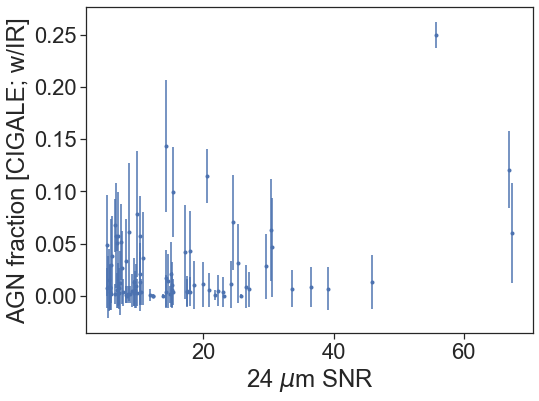

In [10]:
c3 = fits.open('../code_outputs_IR/cigale_UV_FIR_withAGN_2020.fits')

cigale_id = c3[1].data['id']
cigale_agnfracs = c3[1].data['AGNfrac']
cigale_agnfracs_eup = c3[1].data['AGNfrac_err']
cigale_agnfracs_edo = c3[1].data['AGNfrac_err']

c3.close()

plt.plot(f24_snr[(f24_snr>thrs)], cigale_agnfracs[(f24_snr>thrs)],'.')
plt.errorbar(f24_snr[(f24_snr>thrs)], cigale_agnfracs[(f24_snr>thrs)],yerr=[cigale_agnfracs_edo[(f24_snr>thrs)],cigale_agnfracs_eup[(f24_snr>thrs)]],fmt='none')
plt.xlabel(r'24 $\mu$m SNR')
plt.ylabel('AGN fraction [CIGALE; w/IR]')
plt.show()


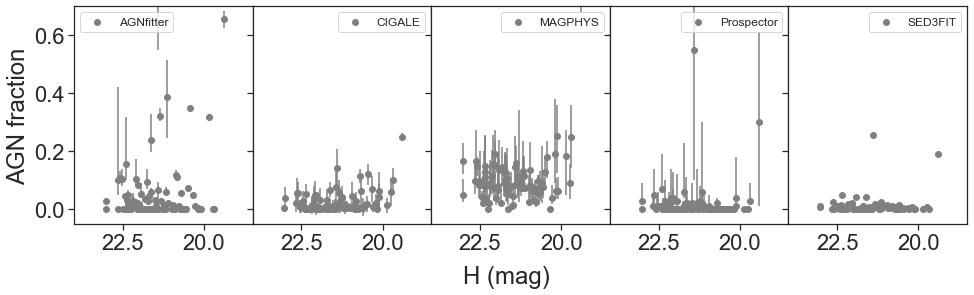

In [15]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(16,4))
axlist = [ax1,ax2,ax3,ax4,ax5]
fig.subplots_adjust(wspace=0)

for a in [ax2,ax3,ax4,ax5]:
    a.set_yticklabels([])

#ax1.plot([-5,5],[-5,5],c='black')
first = ax1.scatter(f160[(f24_snr>thrs)],agnfitter_agnfracs[(f24_snr>thrs)],c='gray', label="AGNfitter")
ax1.errorbar(f160[(f24_snr>thrs)], agnfitter_agnfracs[(f24_snr>thrs)],
             yerr=[agnfitter_agnfracs_edo[(f24_snr>thrs)],agnfitter_agnfracs_eup[(f24_snr>thrs)]],
             fmt='none',c='gray')
ax1.set_xlim(24,18.5)
ax1.set_ylim(-0.05,0.7)
ax1.set_ylabel("AGN fraction")
ax1.legend(prop={'size': 12})

#ax2.plot([-5,5],[-5,5],c='black')
ax2.scatter(f160[(f24_snr>thrs)],cigale_agnfracs[(f24_snr>thrs)],c='gray', label="CIGALE")
ax2.errorbar(f160[(f24_snr>thrs)], cigale_agnfracs[(f24_snr>thrs)],
             yerr=[cigale_agnfracs_edo[(f24_snr>thrs)],cigale_agnfracs_eup[(f24_snr>thrs)]],
             fmt='none',c='gray')
ax2.set_xlim(24,18.5)
ax2.set_ylim(-0.05,0.7)
ax2.legend(prop={'size': 12})

#ax3.plot([-5,5],[-5,5],c='black')
ax3.scatter(f160[(f24_snr>thrs)],magphys_agnfracs_z1_IR[(f24_snr>thrs)],c='gray', label="MAGPHYS")
ax3.errorbar(f160[(f24_snr>thrs)], magphys_agnfracs_z1_IR[(f24_snr>thrs)],
             yerr=[magphys_agnfracs_edo_z1_IR[(f24_snr>thrs)],magphys_agnfracs_eup_z1_IR[(f24_snr>thrs)]],
             fmt='none',c='gray')
ax3.set_xlim(24,18.5)
ax3.set_ylim(-0.05,0.7)
ax3.legend(prop={'size': 12})

#ax4.plot([-5,5],[-5,5],c='black')
ax4.scatter(f160[(f24_snr>thrs)],prospector_agnf[(f24_snr>thrs)],c='gray', label="Prospector")
ax4.errorbar(f160[(f24_snr>thrs)], prospector_agnf[(f24_snr>thrs)], 
             yerr=[prospector_agnfedo[(f24_snr>thrs)],prospector_agnfeup[(f24_snr>thrs)]], 
             fmt='none',c='gray')
ax4.set_xlim(24,18.5)
ax4.set_ylim(-0.05,0.7)
ax4.legend(prop={'size': 12})

#ax5.plot([-5,5],[-5,5],c='black')
ax5.scatter(f160[(f24_snr>thrs)],sed3fit_ir_agnfracs[(f24_snr>thrs)],c='gray', label="SED3FIT")
ax5.set_xlim(24,18.5)
ax5.set_ylim(-0.05,0.7)
ax5.legend(prop={'size': 12})

fig.text(0.5, -0.08, r'H (mag)', ha='center')

plt.savefig("../figures/fig7_agn_frac.png", dpi=600, bbox_inches='tight')

plt.show()